In [1]:
import numpy as np
import pandas as pd

In [2]:
combined_df = pd.read_csv('../combined_df.csv')

In [3]:
from sklearn.model_selection import train_test_split

X = combined_df.drop(['subreddit', 'post'],  axis=1)  # Features
y = combined_df['subreddit']  # Target

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X  , y, test_size=0.2, random_state=42)

# Convert X_train and X_test to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping 

# Step 1: Encode the categorical target variable (y_train) using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))

# Step 2: Flatten the encoded labels
y_train_encoded = y_train_encoded.argmax(axis=1)
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).argmax(axis=1)
y_train_encoded = to_categorical(y_train_encoded)  # Convert to one-hot encoding


In [6]:

# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape X_train to fit the Conv1D input shape
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train the model
model.fit(X_train_reshaped, y_train_encoded, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate on the test set
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).argmax(axis=1)

Epoch 1/10
3745/3745 [==============================] - 184s 49ms/step - loss: 1.6400 - accuracy: 0.4691 - val_loss: 1.4511 - val_accuracy: 0.5139
Epoch 2/10
3745/3745 [==============================] - 89s 24ms/step - loss: 1.2561 - accuracy: 0.5637 - val_loss: 1.1876 - val_accuracy: 0.5879
Epoch 3/10
3745/3745 [==============================] - 56s 15ms/step - loss: 1.1439 - accuracy: 0.5994 - val_loss: 1.1161 - val_accuracy: 0.6063
Epoch 4/10
3745/3745 [==============================] - 27s 7ms/step - loss: 1.0905 - accuracy: 0.6161 - val_loss: 1.0733 - val_accuracy: 0.6207
Epoch 5/10
3745/3745 [==============================] - 25s 7ms/step - loss: 1.0648 - accuracy: 0.6258 - val_loss: 1.0486 - val_accuracy: 0.6308
Epoch 6/10
3745/3745 [==============================] - 22s 6ms/step - loss: 1.0489 - accuracy: 0.6308 - val_loss: 1.0597 - val_accuracy: 0.6279
Epoch 7/10
3745/3745 [==============================] - 21s 6ms/step - loss: 1.0361 - accuracy: 0.6347 - val_loss: 1.0439 - va

In [7]:
# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_classes))

Accuracy: 0.6417089452603472
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.54      0.61      1577
           1       0.81      0.74      0.77      9182
           2       0.72      0.64      0.68      1254
           3       0.75      0.76      0.75     11419
           4       0.54      0.32      0.40      1754
           5       0.77      0.48      0.59      4899
           6       0.56      0.72      0.63     23472
           7       0.66      0.37      0.48      4724
           8       0.77      0.49      0.60      1766
           9       0.41      0.25      0.31      1788
          10       0.60      0.61      0.60     13065

    accuracy                           0.64     74900
   macro avg       0.66      0.54      0.58     74900
weighted avg       0.65      0.64      0.64     74900



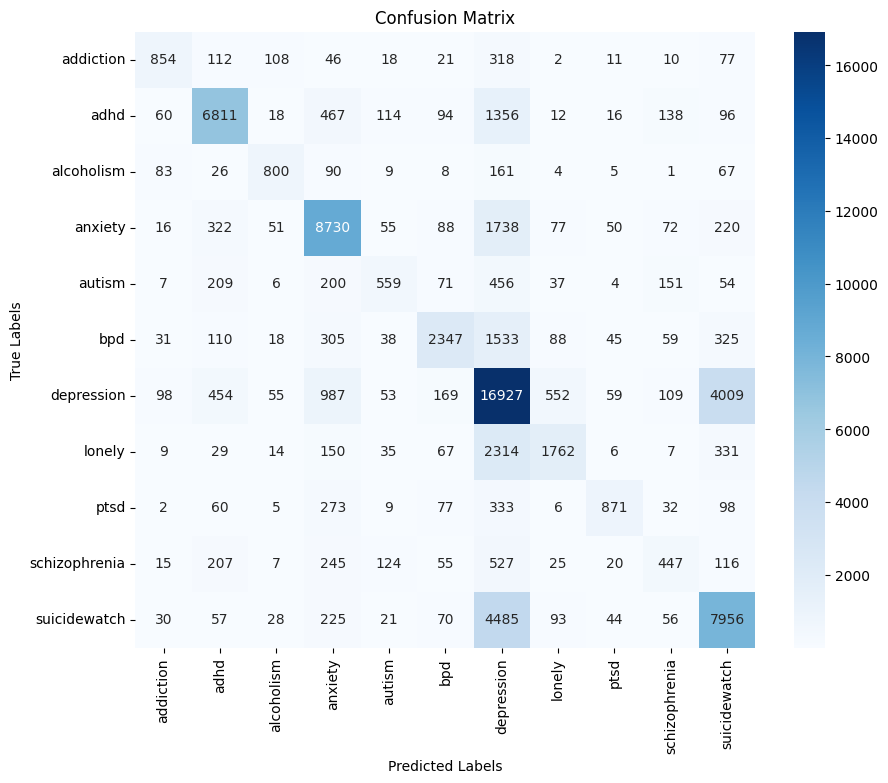

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have predictions in y_pred_classes and the true labels in y_test_encoded

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_classes)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
